<a href="https://colab.research.google.com/github/Louis5228/Digital-Image-Process/blob/main/Edge_detection_and_edge_linking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from skimage import color
from mpl_toolkits.mplot3d import Axes3D
import argparse
import skimage.io as io
import numpy as np
import cv2
import math
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/Digital Image Process/HW5")

In [ ]:
def edgesMarrHildreth(img, sigma):
    '''
            finds the edges using MarrHildreth edge detection method...
            :param im : input image
            :param sigma : sigma is the std-deviation and refers to the spread of gaussian
            :return:
            a binary edge image...
    '''
    size = int(2*(np.ceil(3*sigma))+1)

    x, y = np.meshgrid(np.arange(-size/2+1, size/2+1),
                       np.arange(-size/2+1, size/2+1))

    normal = 1 / (2.0 * np.pi * sigma**2)

    kernel = ((x**2 + y**2 - (2.0*sigma**2)) / sigma**4) * \
        np.exp(-(x**2+y**2) / (2.0*sigma**2)) / normal  # LoG filter

    kern_size = kernel.shape[0]
    log = np.zeros_like(img, dtype=float)

    # applying filter
    for i in range(img.shape[0]-(kern_size-1)):
        for j in range(img.shape[1]-(kern_size-1)):
            window = img[i:i+kern_size, j:j+kern_size] * kernel
            log[i, j] = np.sum(window)

    log = log.astype(np.int64, copy=False)

    zero_crossing_0 = np.zeros_like(log)

    # computing zero crossing
    for i in range(log.shape[0]-(kern_size-1)):
        for j in range(log.shape[1]-(kern_size-1)):
            if log[i][j] == 0:
                if (log[i][j-1] < 0 and log[i][j+1] > 0) or (log[i][j-1] < 0 and log[i][j+1] < 0) or (log[i-1][j] < 0 and log[i+1][j] > 0) or (log[i-1][j] > 0 and log[i+1][j] < 0):
                    zero_crossing_0[i][j] = 255
            if log[i][j] < 0:
                if (log[i][j-1] > 0) or (log[i][j+1] > 0) or (log[i-1][j] > 0) or (log[i+1][j] > 0):
                    zero_crossing_0[i][j] = 255

    zero_crossing_4 = np.zeros((log.shape))
    threshold = np.max(log) * 0.04
    for i in range(log.shape[0]-(kern_size-1)):
      for j in range(log.shape[1]-(kern_size-1)):
        if log[i-1][j]*log[i+1][j] < 0 and (log[i-1][j]-log[i+1][j]) > threshold:
                zero_crossing_4[i][j] = 255
        if log[i][j-1]*log[i][j+1] < 0 and (log[i][j-1]-log[i][j+1]) > threshold:
                zero_crossing_4[i][j] = 255
        if log[i-1][j-1]*log[i+1][j+1] < 0 and (log[i-1][j-1]-log[i+1][j+1]) > threshold:
                zero_crossing_4[i][j] = 255
        if log[i-1][j+1]*log[i-1][j+1] < 0 and (log[i-1][j+1]-log[i-1][j+1]) > threshold:
                zero_crossing_4[i][j] = 255

    return log, zero_crossing_0, zero_crossing_4

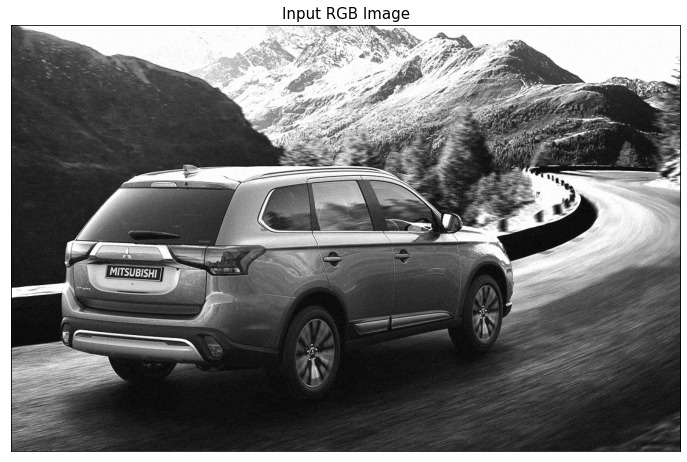

In [142]:
# load image
img = cv2.imread('Car On Mountain Road.tif', cv2.COLOR_BGR2GRAY)
show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,12))
plt.title('Input RGB Image', fontsize = 15), plt.xticks([]), plt.yticks([])
plt.imshow(show_img)
plt.show()

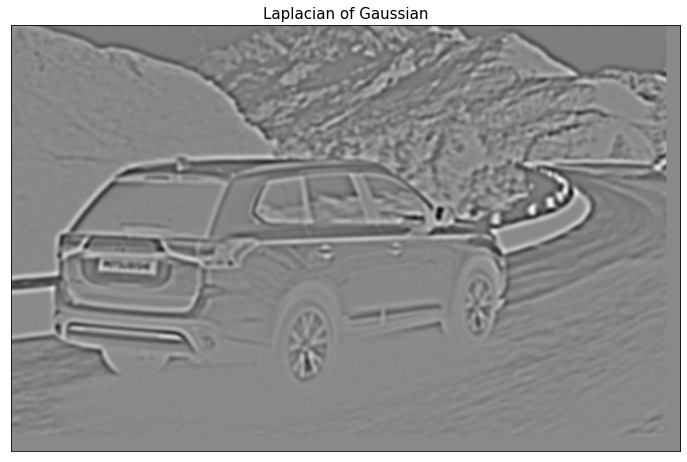

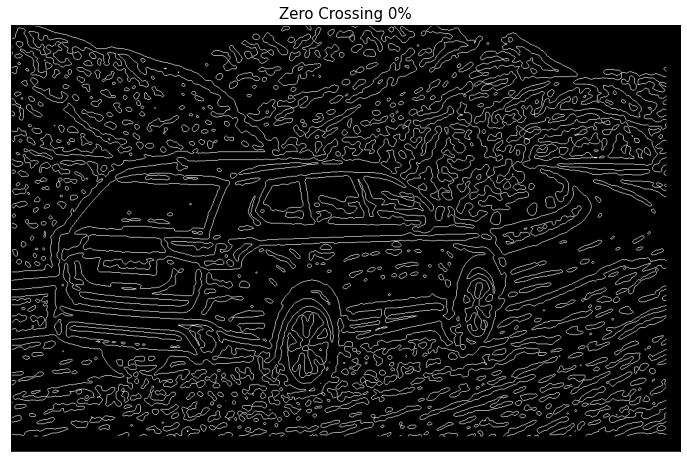

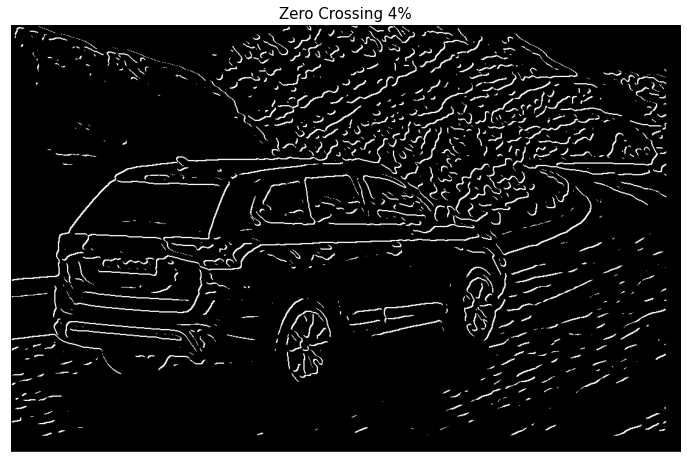

In [ ]:
sigma = 4
log, zero_crossing_0, zero_crossing_4 = edgesMarrHildreth(img, sigma)

plt.figure(figsize=(12,12))
plt.title('Laplacian of Gaussian', fontsize = 15), plt.xticks([]), plt.yticks([])
plt.imshow(log, cmap = 'gray')
plt.show()
plt.figure(figsize=(12,12))
plt.title('Zero Crossing 0%', fontsize = 15), plt.xticks([]), plt.yticks([])
plt.imshow(zero_crossing_0, cmap = 'gray')
plt.show()
plt.figure(figsize=(12,12))
plt.title('Zero Crossing 4%', fontsize = 15), plt.xticks([]), plt.yticks([])
plt.imshow(zero_crossing_4, cmap = 'gray')
plt.show()

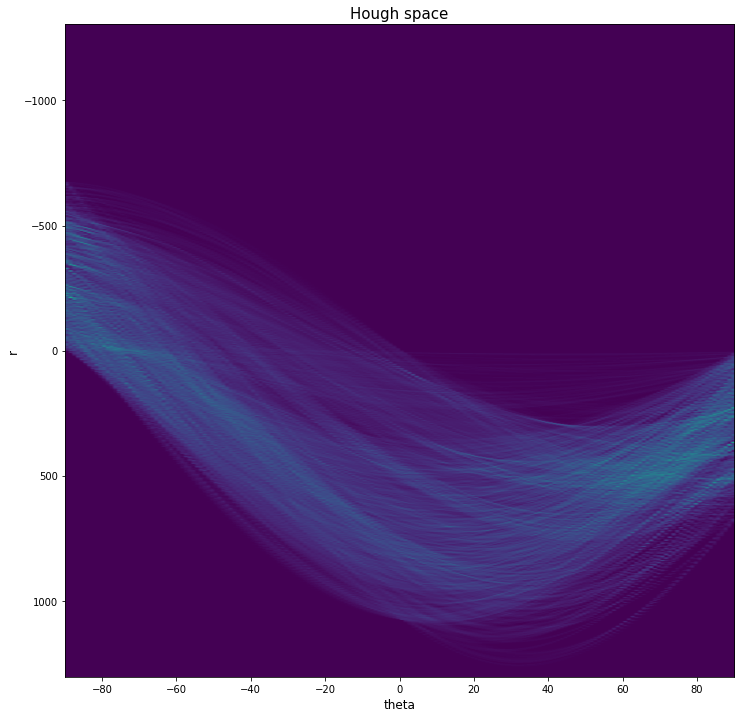

In [85]:
# choose R size
r_step = 1
rmax = np.sqrt(img.shape[0]**2+img.shape[1]**2)
r_vec = np.arange(-rmax, rmax, r_step)

# choose theta size
t_step = np.pi/180
# t_vec = np.arange(0, np.pi, t_step)
t_vec = np.arange(-np.pi/2, np.pi/2, t_step)

# accumulation matrix
acc_mat = np.zeros((r_vec.shape[0], t_vec.shape[0]))

# get indices of edges
edge_inds = np.argwhere(zero_crossing_4 > 0)

# run on all theta and edge indices and find corresponding R
for t_ind, t0 in enumerate(t_vec):
    for yx in edge_inds:
        x = yx[1]
        y = yx[0]

        r0 = x*np.cos(t0)+y*np.sin(t0)
        r_ind = np.argmin(np.abs(r0-r_vec))

        acc_mat[r_ind, t_ind] += 1

plt.figure(figsize=(12,12))
plt.imshow(acc_mat, extent=[-90, 90, rmax, -rmax], aspect='auto')
plt.xlabel('theta',fontsize = 12)
plt.ylabel('r', fontsize = 12)
plt.title('Hough space', fontsize = 15)
plt.show()

linked edges alone


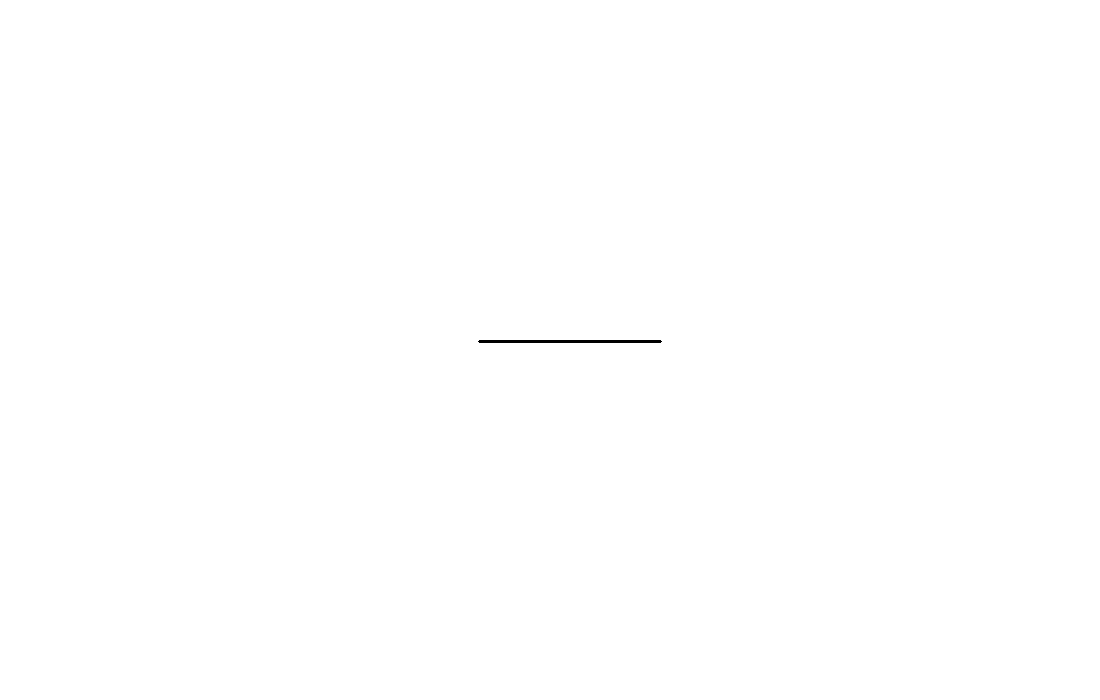

overlapped on the original image


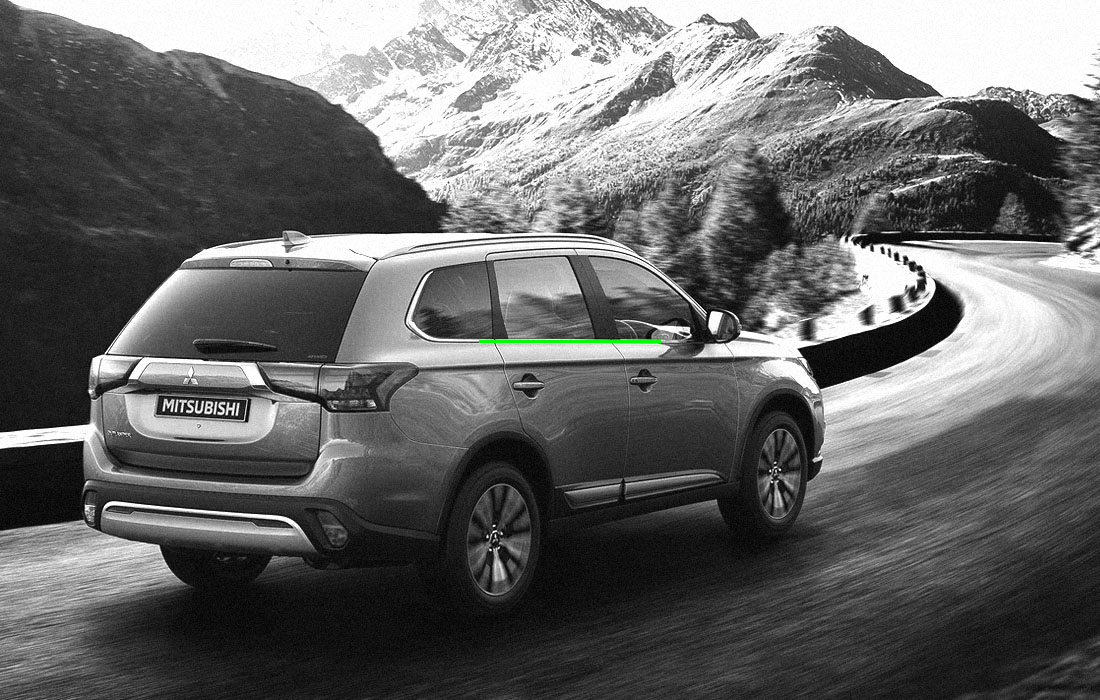

In [153]:
img = cv2.imread('Car On Mountain Road.tif')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize = 3)

# HoughLinesP(image, rho, theta, threshold, lines=None, minLineLength=None, maxLineGap=None)
minLineLength = 1
maxLineGap = 100
lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)

img_shape = img.shape
blank = np.zeros(( img.shape[0],img.shape[1] ))
for x in range(img.shape[0]):
  for y in range(img.shape[1]):
    blank[x][y] = 255

for x1,y1,x2,y2 in lines[0]:
  cv2.line(blank,(x1,y1),(x2,y2),(0,255,0),2)
  cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)


print('linked edges alone')
cv2_imshow(blank)
print('overlapped on the original image')
cv2_imshow(img)